# K-Means Clustering Survey Data

### Installation
`pip install sentence_transformers`

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier

from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

import warnings
warnings.filterwarnings('ignore')

### First define some helper functions (these copied from the initial_eda_and_feature_engineering notebook)

In [2]:
def age_ranges(x):
    res = "Unknown"
    if x < 18: res = "Adolescent"
    if x >= 18 and x < 40: res = "Adult"
    if x >= 40 and x < 60: res = "Middle aged"
    if x >= 60 and x < 70: res = "Senior citizens"
    if x >= 71: res = "Elderly"
    return res

def load_data(cols=[]):
    df = pd.read_csv('survey.csv')

    # So it seems Gender was a free text field and as such is pretty noise. But every row has a value, which is good. There are some obvious fixes:
    # Male, male, M, m, Make, Male (with a space at the end), msle, Mail, Malr, maile, Mal, Cis Male, cis male, Cis Man, Male (CIS) are all 'M'
    # Female, female, F, f, Woman, Female (with a space at the end), femail, Femake, woman, Female (cis), cis-female/femme, Cis Female are all 'F'
    # For simplicity of this exercise I will group all others as 'Other'
    # NOTE: I am a strong supporter of LGBTQ+ rights and such please do not consider this simplification above as anything more for demonstration purposes for this project.
    for gender in ['Male', 'male', 'M', 'm', 'Make', 'Male ', 'msle', 'Mail', 'Malr', 'maile', 'Mal', 'Cis Male', 'cis male', 'Cis Man', 'Male (CIS)', 'Man']:
        df.loc[df['Gender'] == gender, 'Gender'] = 'Male'

    for gender in ['Female', 'female', 'F', 'f', 'Woman', 'Female ', 'femail', 'Femake', 'woman', 'Female (cis)', 'cis-female/femme', 'Cis Female']:
        df.loc[df['Gender'] == gender, 'Gender'] = 'Female'

    df['Gender'] = df['Gender'].apply(lambda x: 'Other' if x not in ['Male', 'Female'] else x)
    
    # A quick look at `comments` shows some interesting info there that could be used in a follow up experiment, but for now I will disregard the `comments` field.
    df.drop('comments', axis=1, inplace=True)

    # Let's look at 'state' first:
    # OK that largely makes sense, right, that the countries are non-US and so seemingly in this data are not using State or a State equivalent.
    # For simplicity lets fill the `nan` US ones with 'CA'.
    df.loc[(df['state'].isna()) & (df['Country'] == 'United States'), 'state'] = df['state'].mode()[0]

    # And set the rest (non-US) to 'N/A'

    df['state'] = df['state'].fillna("N/A")

    # Good, ok let's move on to `self employed`.
    # Interestingly the 18 records that do not have `self_employed` filled are the first 18 in the data_set, so maybe this was not asked fromt eh start.
    # Let's just set them to the mode of the `self_employed` column.
    df.loc[df['self_employed'].isna(), 'self_employed'] = df['self_employed'].mode()[0]

    # So finally, let's look at `work_interfere`.
    # It seems the middle of the road value of 'Sometimes' was the most answer, so let's just use that.
    df.loc[df['work_interfere'].isna(), 'work_interfere'] = df['work_interfere'].mode()[0]

    # Let's bin Age into something categorical.
    df['Age'] = df['Age'].apply(age_ranges)

    # Finally I think we can lose the `TimeStamp'.
    df.drop('Timestamp', axis=1, inplace=True)

    
    # separate continuous and categorical variable columns
    # (Although this is boilerplate I use and not really relvant as we have binned the only numerical column ('Age'))
    continuous_vars = [col for col in df.columns if df[col].dtype != 'object']
    categorical_vars = [col for col in df.columns if df[col].dtype == 'object']
    
    if len(continuous_vars) > 0:
        # Scaling is important for K-Means because K-Means is a distance-based algorithm that clusters data points based on their Euclidean distance from a centroid. If the features in the dataset are not scaled, some of them may be given higher weights than others, which can result in clustering biases towards features with larger magnitudes. This can lead to poor cluster assignments and reduced accuracy
        scaler = MinMaxScaler()
        df_con[continuous_vars] = pd.DataFrame(scaler.fit_transform(df[continuous_vars]))
    else:
        df_con = pd.DataFrame()
    
    if len(categorical_vars) > 0:
        df_cat = pd.get_dummies(df, columns=categorical_vars)
    else:
        df_cat = pd.DataFrame()
        
    df_preprocessed = pd.concat([df_con, df_cat], axis=1)
    
    return df, df_preprocessed

### And then some others

In [3]:
def show_clusters(df_pca, df, col='predicted_cluster'):
    for cluster_number in range(len(df_pca[col].unique())):

        idx = df_pca[df_pca[col] == cluster_number].index

        print('Cluster', str(cluster_number))
        display(df.iloc[idx])
        print('---------------')

In [6]:
def show_scatter(df_pca):
    plt.figure(figsize=(8, 8))

    scat = sns.scatterplot(
        x="component_1",
        y="component_2",
        s=50,
        data=df_pca,
        hue="predicted_cluster",
        palette="Set1",
    )

    # loop through the data and add annotations for each point
    for i in range(len(df_pca)):
        label = int(i)  # get the label from the 'index' column in the data
        x = df_pca.iloc[i]['component_1']  # get the x-coordinate
        y = df_pca.iloc[i]['component_2']  # get the y-coordinate
        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    scat.set_title("Clustering results")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    plt.show()

In [7]:
def get_important_features(df_preprocessed):
    # Train Random Forest classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(df_preprocessed.drop('predicted_cluster', axis=1), df_preprocessed['predicted_cluster'])

    # Get feature importances
    importances = rf.feature_importances_

    # Sort feature importances in descending order
    sorted_indices = importances.argsort()[::-1]

    # Get sorted feature names and importances
    sorted_features = [df_preprocessed.columns[i] for i in sorted_indices]
    sorted_importances = [importances[i] for i in sorted_indices]

    for feature, importance in zip(sorted_features[:10], sorted_importances[:10]):
        print(f"{feature}: {importance}")

    # Plot feature importances as horizontal bar chart
    plt.barh(range(10), sorted_importances[:10], align='center')
    plt.yticks(range(10), sorted_features[:10])
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.show()

 
# What are we trying to do?
Can we identify any natural groupings into personas?

Keep in mind that clustering is an exploratory technique and doesn’t necessarily imply causality. It should be used together with other methods to draw robust conclusions from patient survey responses.

Some questions that would likely yield insightful clusters from this survey include:

- Age, Gender, Country - This can give you basic demographic clusters, e.g. young females in the US, middle-aged males in the UK, etc.
- self_employed, tech_company, remote_work - This can cluster people into groups like tech startup employees, remote freelancers, traditional office employees, etc.
- family_history, treatment, seek_help - This can cluster people into groups like those with a family mental health history who have sought treatment, those with no family history who have still sought help, those with a family history who have not sought help, etc.
- work_interfere, mental_vs_physical, obs_consequence - This can cluster people into groups like those whose work is highly impacted by mental health, those more impacted by physical health, those whose work is not really impacted by health issues, etc.
- benefits, care_options, wellness_program - This can cluster companies/employees into groups like those with strong mental health benefits and support programs, those with moderate benefits and programs, those with little or no mental health support.
- anonymity, coworkers, supervisor - This can cluster people into groups based on how open and understanding their work environment is about mental health issues. E.g. open and accommodating environments, moderately open environments, non-open environments.
- Age, treatment, mental_health_interview - This can cluster people into groups based on their mental health diagnosis and treatment journey, e.g. those diagnosed and treated early in life, those diagnosed and treated later in life, those undiagnosed or untreated, etc.
- No employees, Remote work, Tech company, Benefits, Care options, Wellness program - Company size and culture
- Seek help, Anonymity, Leave, Mental health consequence, Physical health consequence, Coworkers, Supervisor, Mental health interview, Physical health interview, Mental vs physical, Obs consequence - Stigma and consequences

Combining columns across demographics, work life, health experiences and environment can provide very insightful clusters.

In [8]:
questions_area_1 = ['Age', 'Gender', 'Country']

# First try K-Means with One Hot Encoding and Normalization

### First load the data and limit to the questions we want

In [9]:
df, df_preprocessed = load_data(questions_area_1)

Create appropriate pipeline for the preprocessing.
- Principal Component Analysis (PCA) is a dimensionality reduction technique that is used to reduce the number of features in a dataset, while retaining as much of the original variance and information in the dataset as possible. Therefore PCA can be useful for preprocessing data before clustering

In [10]:
preprocessor_pca = Pipeline(
    [
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

In [11]:
preprocessed_X = preprocessor_pca.fit_transform(df_preprocessed)
preprocessed_X

array([[ 1.30543405,  1.08659352],
       [-0.23076014, -1.15372866],
       [-1.53240221,  1.39739704],
       ...,
       [ 0.84618463, -1.72531018],
       [-0.34055413, -1.10717869],
       [ 1.12470909, -1.09519049]])

## But how can we determine the right number of clusters?

There are two good methods we can use to try and determine the appropriate value for k. The elbow method and silhouette method.
- The elbow method involves plotting the relationship between the number of clusters (k) and the sum of squared distances between data points and their assigned cluster center. The ideal k value is the point where the decrease in sum of squared distances starts to level off (i.e., the elbow point)
- The silhouette method involves calculating the average silhouette score for each number of clusters k. The silhouette score measures how similar a data point is to its assigned cluster compared to other clusters. It ranges from -1 to 1, where values closer to 1 indicate that a data point is well matched to its cluster

### Elbow method to select k

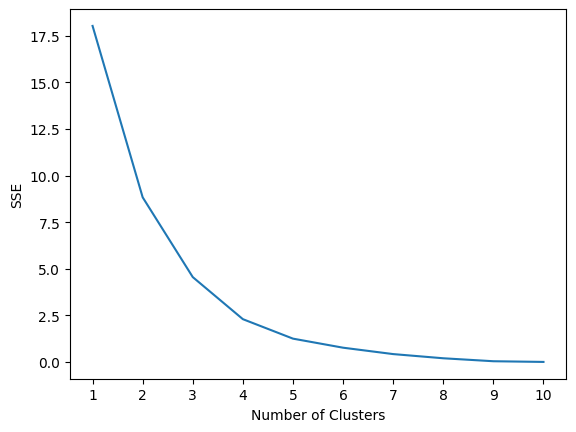

In [13]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 1972,
}

# A list holds the sum of squared errors (SSE) values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(preprocessed_X[:10])
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### Silhouette method to select k

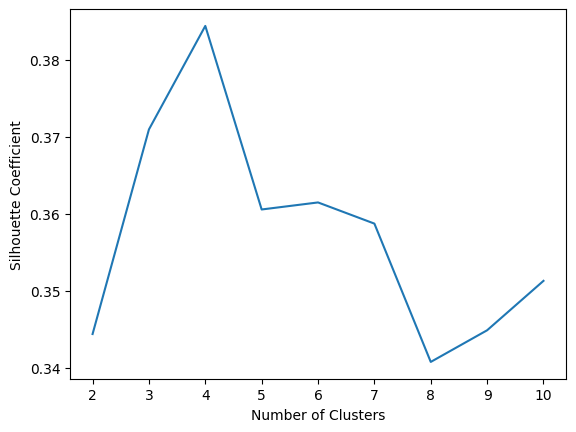

In [14]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice we start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(preprocessed_X)
    score = silhouette_score(preprocessed_X, kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Build K-Means model

In [15]:
# Both methods indicate xxx is a good cluster size, so let's build it with that.
n_clusters = silhouette_coefficients.index(max(silhouette_coefficients)) + 2

print(f"{n_clusters}")

clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

pipe = Pipeline(
    [
        ("preprocessor_pca", preprocessor_pca),
        ("clusterer", clusterer)
    ]
)

_ = pipe.fit(df_preprocessed)

4


In [16]:
predicted_labels = pipe["clusterer"]["kmeans"].labels_
# predicted_labels

In [17]:
silhouette_score(preprocessed_X, predicted_labels)

0.38442501822601755

So silhouette ranges from -1 to 1, so this is not bad - pretty confident :-)
    
### Finally let's look at these as clusters

In [18]:
df_pca = pd.DataFrame(
    pipe["preprocessor_pca"].transform(df_preprocessed),
    columns=["component_1", "component_2"],
)

# Add in the cluster
df_pca["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

df_pca.head()

,component_1,component_2,predicted_cluster
0,1.305453,1.086479,0
1,-0.230743,-1.153884,3
2,-1.532423,1.397281,2
3,-0.370122,-0.584768,1
4,-0.118203,1.020666,2


In [19]:
df_preprocessed['predicted_cluster'] = df_pca['predicted_cluster']

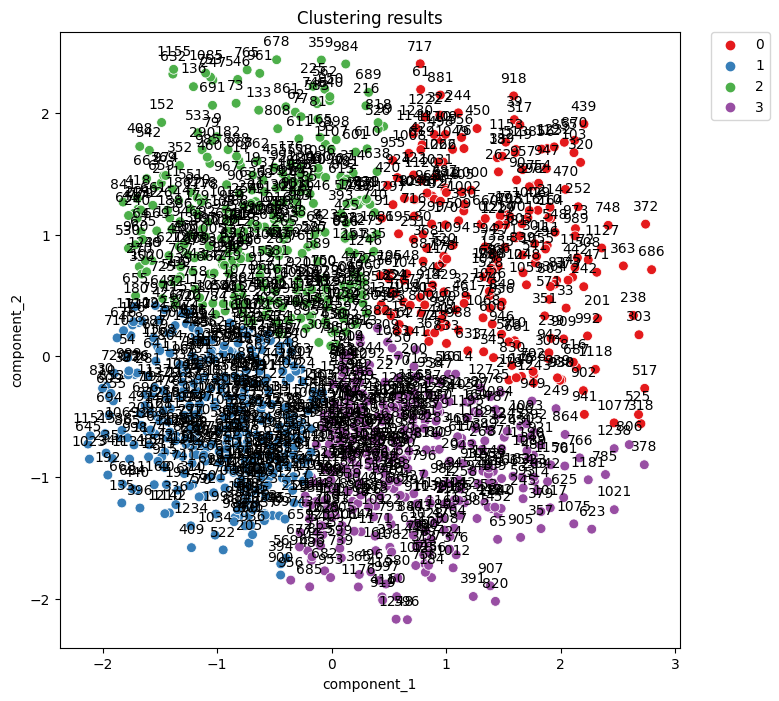

In [20]:
show_scatter(df_pca)

In [21]:
show_clusters(df_pca, df_preprocessed)

Cluster 0


,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,Country_Australia,Country_Austria,...,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_No,obs_consequence_Yes,predicted_cluster
0,False,True,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,True,True,False,0
15,False,True,False,False,False,True,False,False,False,False,...,False,True,False,False,True,False,False,True,False,0
18,False,False,False,True,False,False,True,False,False,False,...,False,False,False,True,False,False,True,False,True,0
24,False,True,False,False,False,False,True,False,False,False,...,False,False,False,True,True,False,False,True,False,0
27,False,True,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,True,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,False,True,False,False,False,False,True,False,False,False,...,True,False,False,True,False,False,True,True,False,0
1243,False,False,False,True,False,True,False,False,False,False,...,False,False,True,False,True,False,False,True,False,0
1249,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,True,True,False,0
1250,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,True,True,False,0


---------------
Cluster 1


,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,Country_Australia,Country_Austria,...,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_No,obs_consequence_Yes,predicted_cluster
3,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,True,False,False,True,1
16,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,True,False,True,False,1
23,False,False,False,True,False,False,True,False,False,False,...,False,False,False,True,True,False,False,True,False,1
26,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,True,False,False,True,False,1
28,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,True,False,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,True,False,False,True,False,1
1244,False,True,False,False,False,True,False,False,False,False,...,False,False,False,True,False,True,False,True,False,1
1247,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,True,False,False,False,True,1
1254,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,True,False,False,True,False,1


---------------
Cluster 2


,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,Country_Australia,Country_Austria,...,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_No,obs_consequence_Yes,predicted_cluster
2,False,True,False,False,False,False,True,False,False,False,...,True,False,False,True,False,True,False,True,False,2
4,False,True,False,False,False,False,True,False,False,False,...,True,False,False,True,True,False,False,True,False,2
5,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,True,False,False,True,False,2
7,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,True,False,True,False,2
9,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,True,True,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,False,True,False,False,False,True,False,False,False,False,...,False,True,False,False,True,False,False,True,False,2
1233,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,True,False,False,True,False,2
1239,False,True,False,False,False,False,True,False,False,False,...,False,False,False,True,True,False,False,True,False,2
1246,False,True,False,False,False,False,True,False,False,False,...,False,False,False,True,True,False,False,True,False,2


---------------
Cluster 3


,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,Country_Australia,Country_Austria,...,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_No,obs_consequence_Yes,predicted_cluster
1,False,False,False,True,False,False,True,False,False,False,...,False,False,True,False,True,False,False,True,False,3
6,False,True,False,False,False,True,False,False,False,False,...,False,False,True,False,True,False,False,True,False,3
8,False,False,False,True,False,True,False,False,False,False,...,False,True,False,False,False,True,False,True,False,3
12,False,False,False,True,False,True,False,False,False,False,...,False,True,False,False,False,True,False,False,True,3
17,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,True,False,True,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,False,False,False,True,False,True,False,False,False,False,...,False,False,True,False,True,False,False,True,False,3
1252,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,True,False,True,False,3
1253,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,True,False,False,True,False,3
1256,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,True,False,True,False,3


---------------


mental_health_consequence_No: 0.07003213272403955
benefits_Yes: 0.05825457099198564
supervisor_Yes: 0.05521204868376917
supervisor_No: 0.03554431900727259
treatment_No: 0.027259834071549922
mental_health_consequence_Maybe: 0.026632392165217143
treatment_Yes: 0.024928611438967862
care_options_Yes: 0.0247015387455822
seek_help_Yes: 0.02292629989049428
Country_United States: 0.022815726709540244


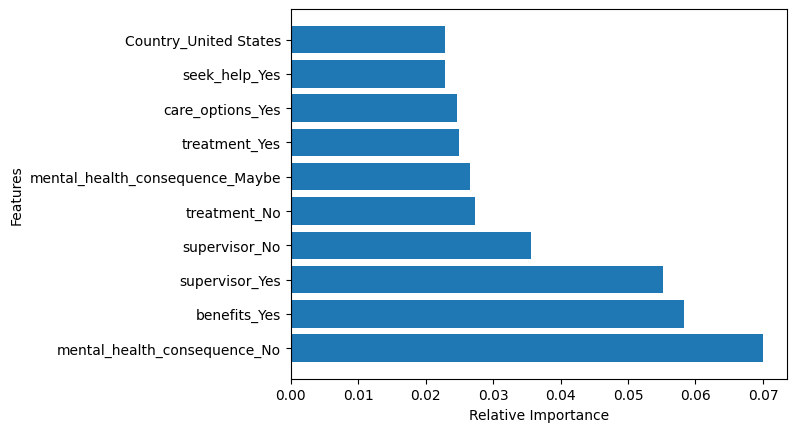

In [22]:
get_important_features(df_preprocessed)

# 
# Using LLM's for embeddings rather than One Hot Encodings and Normalization
https://medium.com/@swansburg.justin/how-to-use-llms-to-build-better-clustering-models-9b17a5491bb4

### First load the data and limit to the questions we want

In [24]:
df, df_preprocessed = load_data(questions_area_1)

In [26]:
sbert_model = SentenceTransformer(r"sentence-transformers/paraphrase-MiniLM-L6-v2")

def compile_text(df):
    res = {}
    for idx, row in df.iterrows():
        text = ""
        for col in df.columns:
            if row[col] != "": 
                text += f'{col}: "{row[col]}"\n'
#         print(text)
#         print("-----------")
        res[idx] = output_embedding(text.strip()).values[0]
    return pd.DataFrame(res).T

def output_embedding(txt):
    embd = sbert_model.encode(txt)
    return pd.DataFrame(embd.reshape(-1, 384))

df_embed = compile_text(df)
df_embed.shape

(1259, 384)

In [27]:
df_embed.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.357499,-0.054169,0.214809,-0.046766,-0.240472,-0.053728,0.083142,-0.260867,-0.086158,0.045789,...,0.039011,0.204443,0.212176,-0.139979,0.002539,-0.040105,0.635228,-0.358543,0.050066,0.085088
1,0.359006,0.041189,0.116035,-0.134159,-0.209867,0.144887,0.084733,-0.176036,-0.090213,0.034219,...,0.091289,0.214187,0.112087,-0.042824,-0.102438,-0.108569,0.548222,-0.384913,-0.138271,0.277210
2,0.473806,-0.001060,0.062270,0.011444,-0.069302,0.017452,0.096390,-0.163753,-0.107719,0.126890,...,0.063780,0.194825,0.096397,0.013099,-0.092489,-0.154703,0.401356,-0.422071,-0.022308,0.109369
3,0.480532,-0.059009,0.207103,-0.076631,-0.209996,-0.150535,0.005348,-0.288704,-0.103922,0.125073,...,0.158978,0.205550,0.265051,-0.067587,-0.108234,-0.062863,0.649515,-0.395652,0.137254,0.037829
4,0.367018,0.012184,0.142403,-0.090104,-0.215303,0.057743,0.082757,-0.206350,-0.053723,0.050660,...,0.073720,0.219782,0.179877,-0.081502,-0.100017,-0.142865,0.526860,-0.377010,-0.027843,0.175363


In [28]:
preprocessor_2 = Pipeline(
    [
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

preprocessor_2 = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

In [29]:
preprocessed_X = preprocessor_2.fit_transform(df_embed)
preprocessed_X.shape

(1259, 2)

### Elbow method to select k

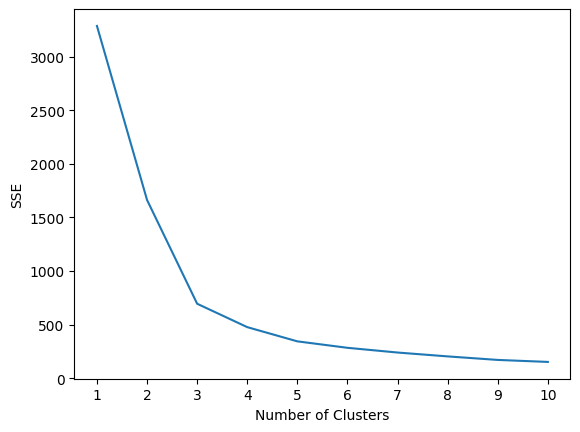

In [30]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 1972,
}

# A list holds the sum of squared errors (SSE) values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(preprocessed_X)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### Silhouette method to select k

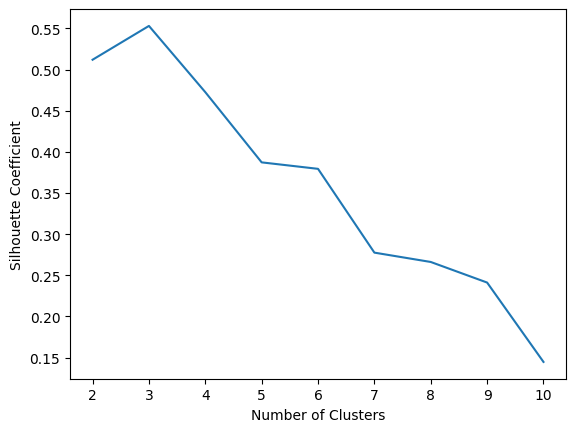

In [31]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice we start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_embed)
    score = silhouette_score(preprocessed_X, kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Build K-Means model

In [32]:
# Both methods indicate xxx is a good cluster size, so let's build it with that.
n_clusters = silhouette_coefficients.index(max(silhouette_coefficients)) + 2

print(f"{n_clusters=}")

clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)


pipe = Pipeline(
    [
        ("preprocessor", preprocessor_2),
        ("clusterer", clusterer)
    ]
)

_ = pipe.fit(df_embed)

n_clusters=3


In [33]:
predicted_labels = pipe["clusterer"]["kmeans"].labels_
predicted_labels

array([0, 2, 2, ..., 0, 0, 0])

In [34]:
silhouette_score(preprocessed_X, predicted_labels)

0.57328516

So silhouette ranges from -1 to 1, so this is not bad - pretty confident :-)
    
### Finally let's look at these as clusters

In [35]:
df_pca = pd.DataFrame(
    pipe["preprocessor"].transform(df_embed),
    columns=["component_1", "component_2"],
)

# Add in the cluster
df_pca["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

df_pca.head()

,component_1,component_2,predicted_cluster
0,-0.804829,-0.467305,0
1,-0.262905,1.243276,2
2,1.450444,1.537762,2
3,2.317278,-1.716312,1
4,-1.160140,0.295308,0


In [36]:
df_preprocessed['predicted_cluster'] = df_pca['predicted_cluster']

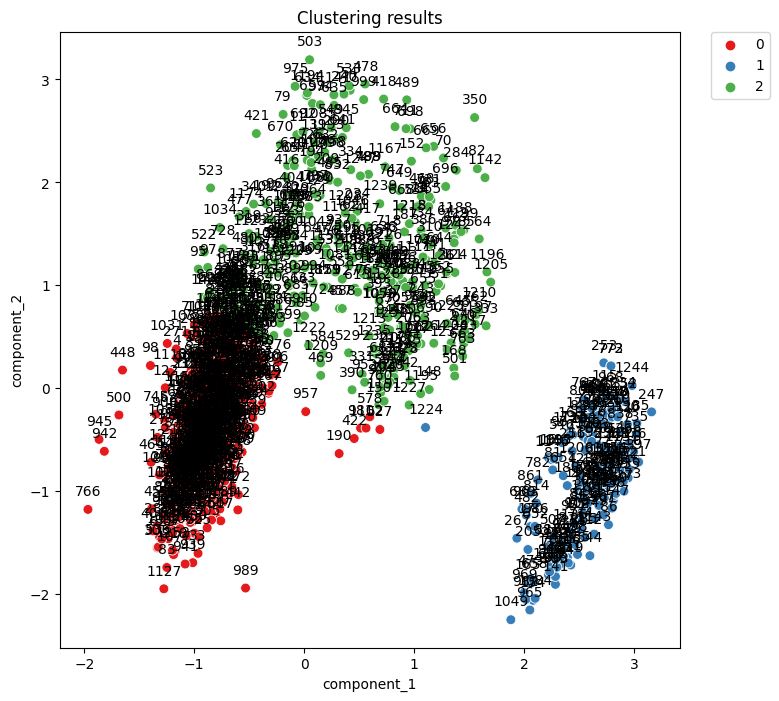

In [37]:
show_scatter(df_pca)

In [38]:
show_clusters(df_pca, df_preprocessed)

Cluster 0


,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,Country_Australia,Country_Austria,...,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_No,obs_consequence_Yes,predicted_cluster
0,False,True,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,True,True,False,0
4,False,True,False,False,False,False,True,False,False,False,...,True,False,False,True,True,False,False,True,False,0
5,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,True,False,False,True,False,0
6,False,True,False,False,False,True,False,False,False,False,...,False,False,True,False,True,False,False,True,False,0
8,False,False,False,True,False,True,False,False,False,False,...,False,True,False,False,False,True,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,True,False,False,True,False,0
1255,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,True,False,0
1256,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,True,False,True,False,0
1257,False,False,False,True,False,True,False,False,False,False,...,False,False,True,False,False,True,False,True,False,0


---------------
Cluster 1


,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,Country_Australia,Country_Austria,...,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_No,obs_consequence_Yes,predicted_cluster
3,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,True,False,False,True,1
16,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,True,False,True,False,1
29,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,True,False,True,False,1
30,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,True,False,True,False,1
32,False,True,False,False,False,False,True,False,False,False,...,False,False,False,True,True,False,False,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,False,True,False,False,False,False,True,False,False,False,...,True,False,False,True,False,False,True,True,False,1
1233,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,True,False,False,True,False,1
1234,False,True,False,False,False,False,False,True,False,False,...,False,True,False,False,True,False,False,True,False,1
1244,False,True,False,False,False,True,False,False,False,False,...,False,False,False,True,False,True,False,True,False,1


---------------
Cluster 2


,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,Country_Australia,Country_Austria,...,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_No,obs_consequence_Yes,predicted_cluster
1,False,False,False,True,False,False,True,False,False,False,...,False,False,True,False,True,False,False,True,False,2
2,False,True,False,False,False,False,True,False,False,False,...,True,False,False,True,False,True,False,True,False,2
7,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,True,False,True,False,2
9,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,True,True,False,2
11,False,True,False,False,False,False,True,False,False,False,...,True,False,False,True,True,False,False,True,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,True,False,False,True,False,2
1241,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,True,False,False,True,False,2
1242,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,True,False,False,True,False,2
1247,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,True,False,False,False,True,2


---------------


Country_United Kingdom: 0.18597684175312948
Country_United States: 0.15601011422465408
state_N/A: 0.14355589758376344
benefits_Yes: 0.026066450746369242
Country_Canada: 0.02599205980227723
Country_Germany: 0.019633213633206918
benefits_Don't know: 0.016309022060552472
family_history_Yes: 0.0152025289099924
benefits_No: 0.014723659307213628
family_history_No: 0.012180708509003586


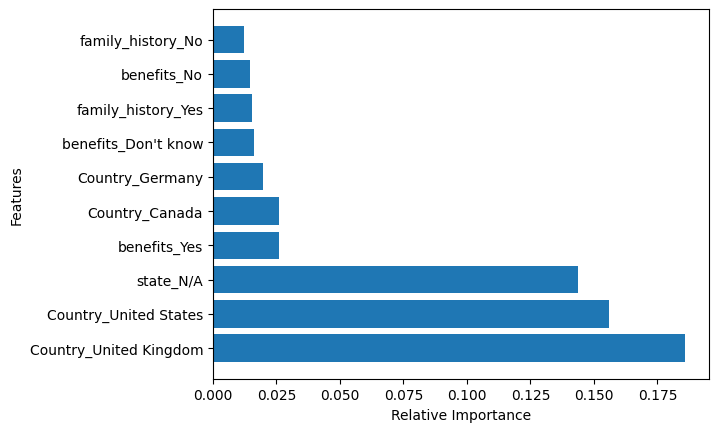

In [39]:
get_important_features(df_preprocessed)